In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Set to the GPU you want to use, or leave empty for CPU
import pickle


import arviz as az
import xarray as xr

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import jax.numpy as jnp

from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from odisseo.units import CodeUnits
from chainconsumer import Chain, ChainConsumer, Truth



In [2]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  

config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = False, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          softening = (0.1 * u.pc).to(code_units.code_length).value,) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 

## Langevine chains

In [3]:
def list_of_dicts_to_dataframe(samples_list, chain_id=0):
    """
    Convert a list of dictionaries (MCMC samples) to DataFrame with proper indexing.
    
    Parameters:
    -----------
    samples_list : list of dict
        List where each element is a dictionary of parameter samples
    chain_id : int
        Chain identifier for this particular chain
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with MultiIndex (chain, draw) and parameter columns
    """
    
    # Convert list of dicts to DataFrame
    df = pd.DataFrame(samples_list)
    
    # Add chain and draw indices
    n_draws = len(samples_list)
    df['chain'] = chain_id
    df['draw'] = np.arange(n_draws)
    
    # Set MultiIndex
    df = df.set_index(['chain', 'draw'])
    
    return df

def multiple_lists_to_dataframe(list_of_samples_lists):
    """
    Convert multiple lists of dictionaries to a single DataFrame.
    
    Parameters:
    -----------
    list_of_samples_lists : list of lists
        Each element is a list of dictionaries (one chain)
    
    Returns:
    --------
    pd.DataFrame
        Combined DataFrame with all chains
    """
    
    all_dfs = []
    
    for chain_id, samples_list in enumerate(list_of_samples_lists):
        df_chain = list_of_dicts_to_dataframe(samples_list, chain_id)
        all_dfs.append(df_chain)
    
    # Concatenate all chains
    combined_df = pd.concat(all_dfs, axis=0)
    
    return combined_df

def mcmc_samples_to_arviz_dataframe(samples_data, code_units, params, apply_log_transform=True):
    """
    Convert MCMC samples to DataFrame ready for ArviZ analysis.
    
    Parameters:
    -----------
    samples_data : list or list of lists
        MCMC samples as list(s) of dictionaries
    code_units : CodeUnits
        Your code units object
    params : SimulationParams
        Your simulation parameters for truth values
    apply_log_transform : bool
        Whether to apply 10** transform and unit conversion
    
    Returns:
    --------
    pd.DataFrame, dict
        DataFrame for ArviZ and truth values dictionary
    """
    
    # Handle different input formats
    if isinstance(samples_data[0], dict):
        # Single chain: list of dictionaries
        df = list_of_dicts_to_dataframe(samples_data, chain_id=0)
    else:
        # Multiple chains: list of lists of dictionaries
        df = multiple_lists_to_dataframe(samples_data)
    
    # Convert to float
    df = df.astype(float)
    
    if apply_log_transform:
        # Apply transformations and unit conversions
        if 'M_NFW' in df.columns:
            df['M_NFW'] = 10**df['M_NFW'] * code_units.code_mass.to(u.Msun)
        if 't_end' in df.columns:
            df['t_end'] = 10**df['t_end'] * code_units.code_time.to(u.Gyr)
        if 'M_plummer' in df.columns:
            df['M_plummer'] = 10**df['M_plummer'] * code_units.code_mass.to(u.Msun)
        if 'M_MN' in df.columns:
            df['M_MN'] = 10**df['M_MN'] * code_units.code_mass.to(u.Msun)
    
    # Create truth values
    truth_values = {}
    if hasattr(params, 'NFW_params'):
        truth_values['M_NFW'] = params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)
    if hasattr(params, 't_end'):
        truth_values['t_end'] = params.t_end * code_units.code_time.to(u.Gyr)
    if hasattr(params, 'Plummer_params'):
        truth_values['M_plummer'] = params.Plummer_params.Mtot * code_units.code_mass.to(u.Msun)
    if hasattr(params, 'MN_params'):
        truth_values['M_MN'] = params.MN_params.M * code_units.code_mass.to(u.Msun)
    
    return df, truth_values

Parameter M_plummer in chain MCMC samples is not constrained
Parameter M_NFW in chain MCMC samples is not constrained
Parameter M_MN in chain MCMC samples is not constrained


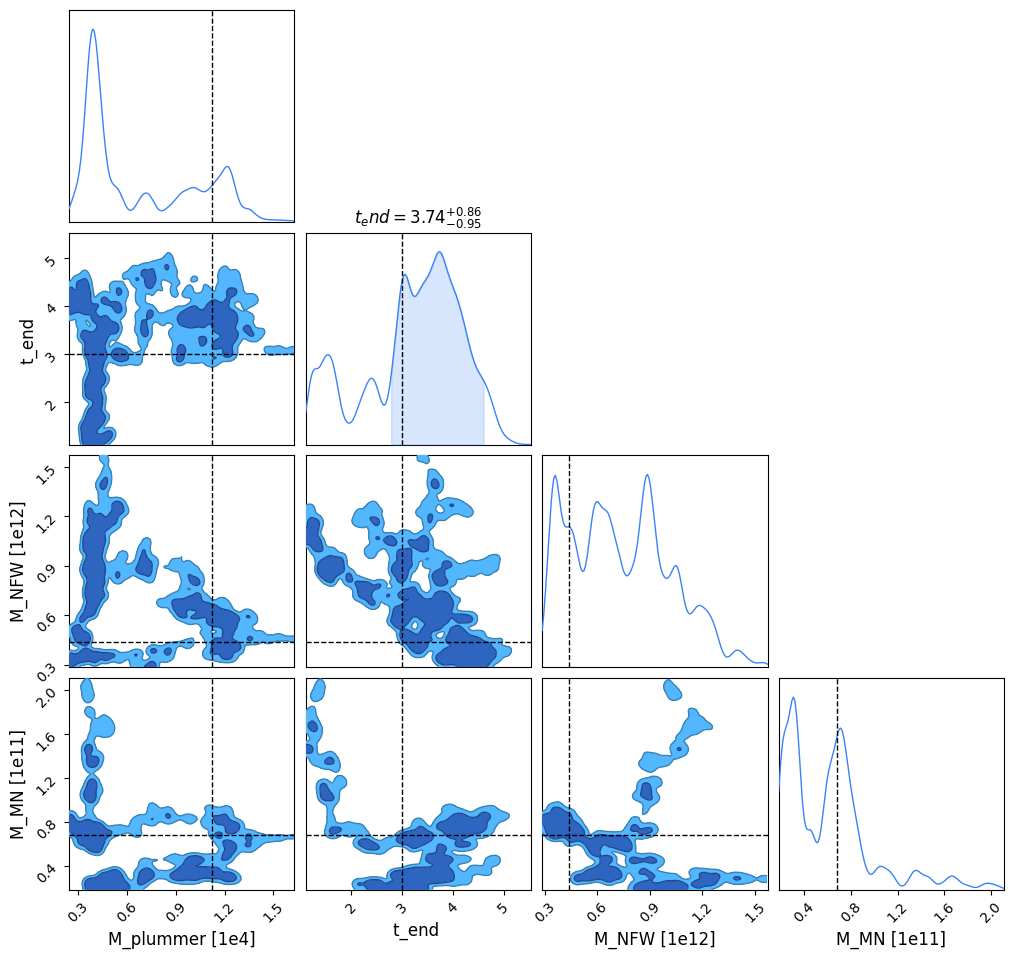

In [4]:
list_of_list_of_dictionaries = []
for i in range(2):
    with open(f'langevine_chain_observatoinal_error_{i}.pkl', 'rb') as f:
        list_of_list_of_dictionaries.append(pickle.load(f))


# Convert to DataFrame
df_chains, truth_vals = mcmc_samples_to_arviz_dataframe(
    list_of_list_of_dictionaries, 
    code_units, 
    params, 
    apply_log_transform=True
)

# Create ArviZ InferenceData
xdata = xr.Dataset.from_dataframe(df_chains)
idata = az.InferenceData(posterior=xdata)

# Use with ChainConsumer
c = ChainConsumer()
c.add_chain(Chain(samples=df_chains, name='MCMC samples'))
c.add_truth(Truth(location=truth_vals))
fig = c.plotter.plot()

                   mean            sd        hdi_3%       hdi_97%  \
M_plummer  6.830360e+03  3.497933e+03  2.783226e+03  1.267586e+04   
t_end      3.233000e+00  9.580000e-01  1.158000e+00  4.532000e+00   
M_NFW      7.366251e+11  2.804763e+11  2.980977e+11  1.214067e+12   
M_MN       6.169136e+10  3.749324e+10  1.804503e+10  1.372727e+11   

              mcse_mean       mcse_sd  ess_bulk  ess_tail  r_hat  
M_plummer  2.011500e+03  6.816120e+02       4.0      17.0   1.60  
t_end      5.720000e-01  2.800000e-01       3.0      11.0   1.75  
M_NFW      1.808068e+11  6.377857e+10       2.0      14.0   2.30  
M_MN       2.168595e+10  1.289493e+10       3.0      11.0   2.05  


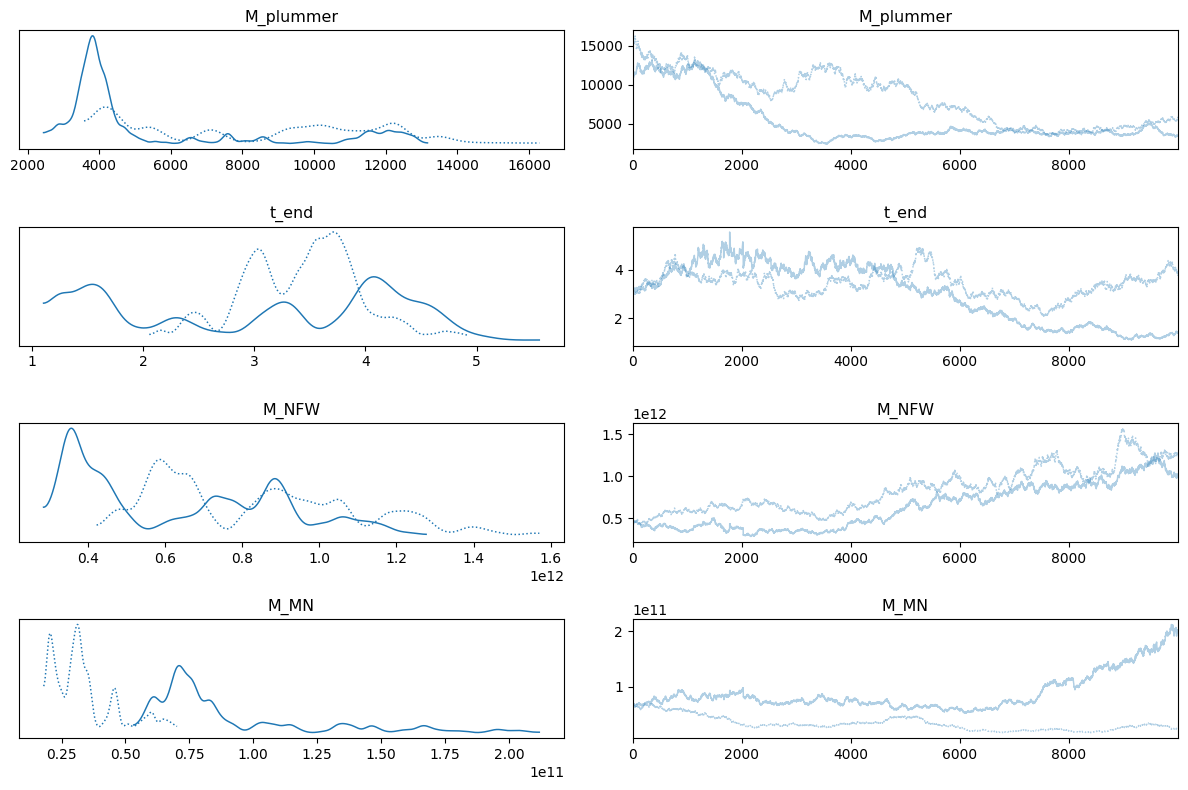

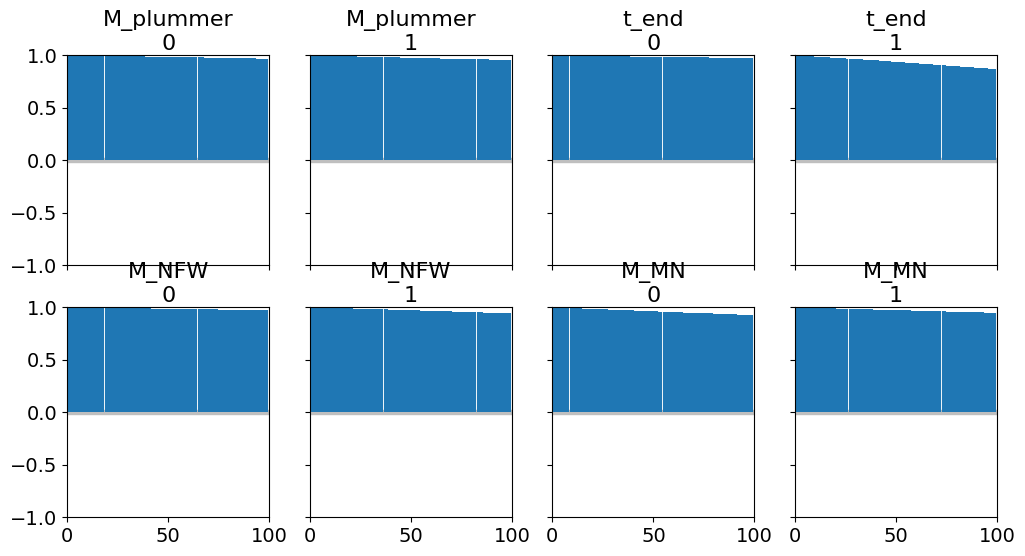

Effective Sample Size:
<xarray.Dataset> Size: 32B
Dimensions:    ()
Data variables:
    M_plummer  float64 8B 4.334
    t_end      float64 8B 3.1
    M_NFW      float64 8B 2.485
    M_MN       float64 8B 2.701
Monte Carlo Standard Error:
<xarray.Dataset> Size: 32B
Dimensions:    ()
Data variables:
    M_plummer  float64 8B 2.011e+03
    t_end      float64 8B 0.572
    M_NFW      float64 8B 1.808e+11
    M_MN       float64 8B 2.169e+10


In [5]:
# Summary statistics including R-hat, ESS, etc.
summary = az.summary(idata)
print(summary)

# Plot trace plots to visualize convergence
az.plot_trace(idata, figsize=(12, 8))
plt.tight_layout()
plt.show()

# Plot autocorrelation
az.plot_autocorr(idata, figsize=(12, 6))
plt.show()

# Effective sample size
ess = az.ess(idata)
print("Effective Sample Size:")
print(ess)

# Monte Carlo Standard Error
mcse = az.mcse(idata)
print("Monte Carlo Standard Error:")
print(mcse)

In [6]:
def detect_burnin_automatic(idata, var_names=None, method='rank'):
    """
    Automatically detect burn-in using multiple methods
    """
    if var_names is None:
        var_names = list(idata.posterior.data_vars)
    
    burnin_estimates = {}
    
    for var in var_names:
        samples = idata.posterior[var].values
        n_draws = samples.shape[-1]
        
        if method == 'rank':
            # Use rank plot statistic to detect burn-in
            # Look for where rank statistics stabilize
            rank_stats = []
            for i in range(100, n_draws, 50):  # Check every 50 samples after 100
                temp_data = idata.sel(draw=slice(i, None))
                # rank_stat = az.rank_plot(temp_data, var_names=[var], show=False)
                # Extract some measure of rank uniformity (simplified)
                rank_stats.append(i)
            
            # Simple heuristic: use 20% of chain length as burn-in
            burnin_estimates[var] = n_draws // 5
            
        elif method == 'running_mean':
            # Detect when running mean stabilizes
            flattened = samples.flatten()
            running_mean = np.cumsum(flattened) / np.arange(1, len(flattened) + 1)
            
            # Find where the running mean stabilizes (change < 1%)
            changes = np.abs(np.diff(running_mean) / running_mean[:-1])
            stable_idx = np.where(changes < 0.01)[0]
            
            if len(stable_idx) > 0:
                burnin_estimates[var] = stable_idx[0] // samples.shape[0]  # Convert back to draws
            else:
                burnin_estimates[var] = n_draws // 5  # Default to 20%
    
    # Take the maximum across all variables for safety
    recommended_burnin = max(burnin_estimates.values())
    
    print("=== BURN-IN DETECTION ===")
    for var, burnin in burnin_estimates.items():
        print(f"{var}: {burnin} samples")
    print(f"\nRecommended burn-in: {recommended_burnin} samples")
    
    return recommended_burnin, burnin_estimates

# Detect burn-in automatically
burnin_samples, burnin_by_var = detect_burnin_automatic(idata)

=== BURN-IN DETECTION ===
M_plummer: 2000 samples
t_end: 2000 samples
M_NFW: 2000 samples
M_MN: 2000 samples

Recommended burn-in: 2000 samples


In [7]:
# Apply burn-in by removing the first N samples
burn_in_samples = 2000  # Number of samples to remove from the beginning

# Method 1: Using slice
idata_burned = idata.sel(draw=slice(burn_in_samples, None))

# Method 2: Using isel (integer indexing)
idata_burned = idata.isel(draw=slice(burn_in_samples, None))

print(f"Original shape: {idata.posterior.dims}")
print(f"After burn-in: {idata_burned.posterior.dims}")

Original shape: FrozenMappingWarningOnValuesAccess({'chain': 2, 'draw': 10000})
After burn-in: FrozenMappingWarningOnValuesAccess({'chain': 2, 'draw': 8000})


                   mean            sd        hdi_3%       hdi_97%  \
M_plummer  5.588042e+03  2.636454e+03  2.488007e+03  1.076784e+04   
t_end      3.067000e+00  9.740000e-01  1.158000e+00  4.412000e+00   
M_NFW      7.988678e+11  2.764177e+11  2.973435e+11  1.235706e+12   
M_MN       6.026560e+10  4.106852e+10  1.801362e+10  1.455626e+11   

              mcse_mean       mcse_sd  ess_bulk  ess_tail  r_hat  
M_plummer  1.718153e+03  9.907670e+02       3.0      21.0   1.82  
t_end      6.140000e-01  2.700000e-01       3.0      12.0   1.82  
M_NFW      1.684860e+11  6.242360e+10       3.0      13.0   1.93  
M_MN       2.525646e+10  1.562219e+10       2.0      11.0   2.35  


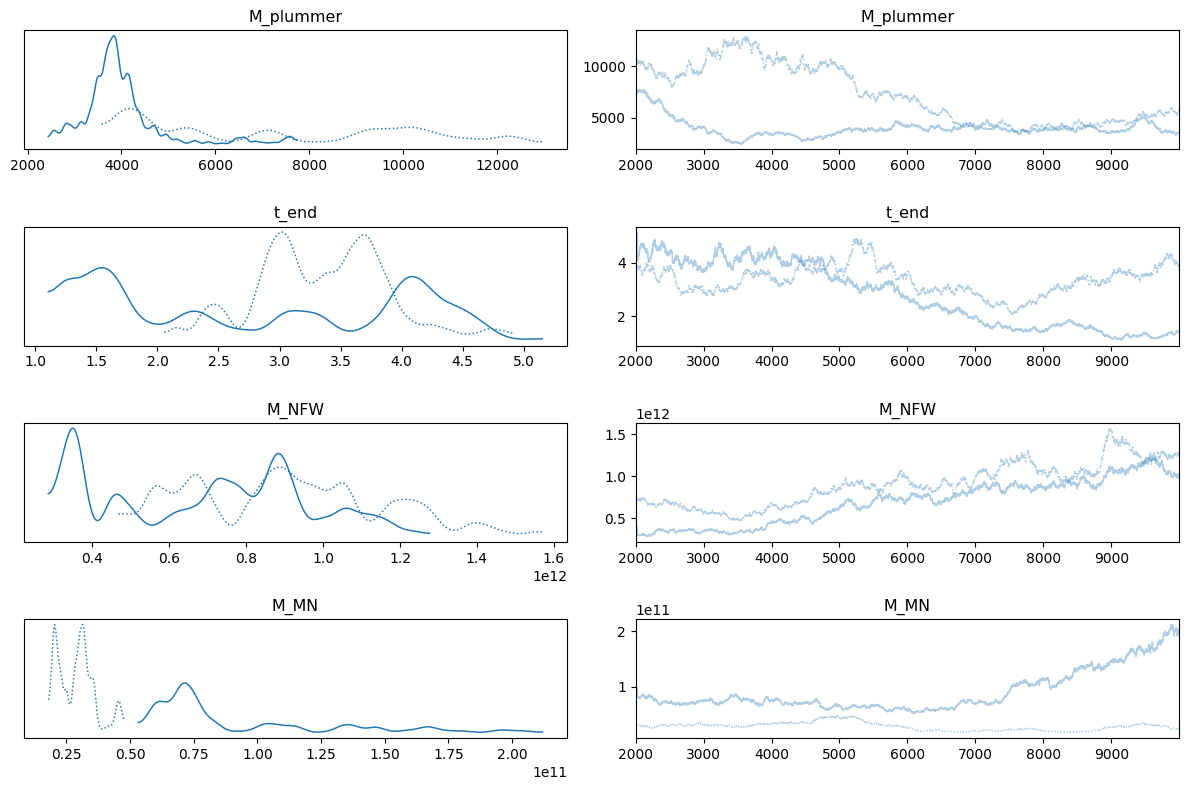

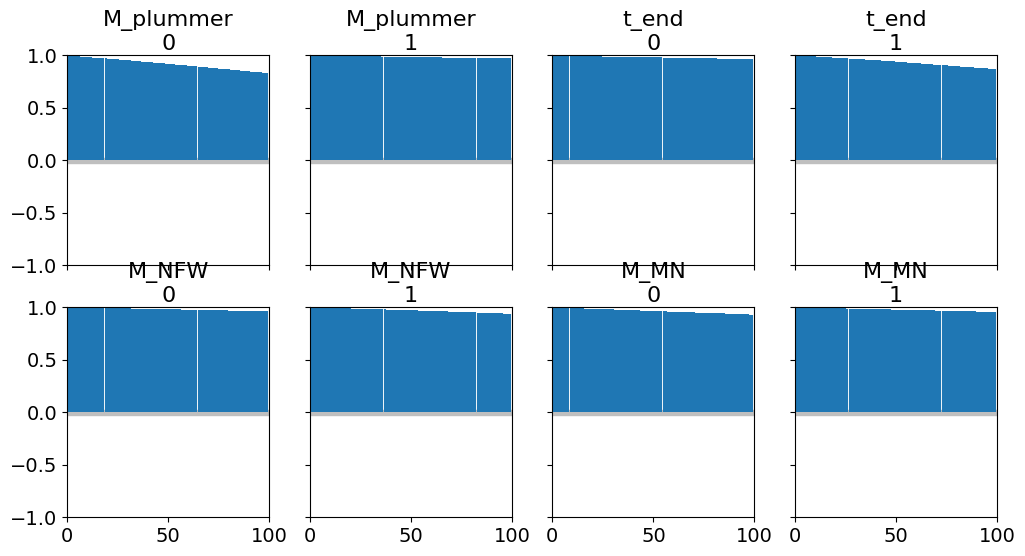

Effective Sample Size:
<xarray.Dataset> Size: 32B
Dimensions:    ()
Data variables:
    M_plummer  float64 8B 3.048
    t_end      float64 8B 2.907
    M_NFW      float64 8B 2.783
    M_MN       float64 8B 2.465
Monte Carlo Standard Error:
<xarray.Dataset> Size: 32B
Dimensions:    ()
Data variables:
    M_plummer  float64 8B 1.718e+03
    t_end      float64 8B 0.6143
    M_NFW      float64 8B 1.685e+11
    M_MN       float64 8B 2.526e+10


In [8]:
# Summary statistics including R-hat, ESS, etc.
summary = az.summary(idata_burned)
print(summary)

# Plot trace plots to visualize convergence
az.plot_trace(idata_burned, figsize=(12, 8))
plt.tight_layout()
plt.show()

# Plot autocorrelation
az.plot_autocorr(idata_burned, figsize=(12, 6))
plt.show()

# Effective sample size
ess = az.ess(idata_burned)
print("Effective Sample Size:")
print(ess)

# Monte Carlo Standard Error
mcse = az.mcse(idata_burned)
print("Monte Carlo Standard Error:")
print(mcse)

In [6]:
# Method 1: Using stack and unstack
def array_to_dataframe(arr):
    # Create MultiIndex for the reshaped data
    n_draws, n_params, n_chains = arr.shape
    
    # Reshape to (draws * chains, parameters)
    reshaped = arr.transpose(0, 2, 1).reshape(-1, n_params)
    
    # Create the multi-index
    draw_idx = np.tile(np.arange(n_draws), n_chains)
    chain_idx = np.repeat(np.arange(n_chains), n_draws)
    
    # Create DataFrame
    df = pd.DataFrame(reshaped, columns=['M_NFW', 't_end'])
    df['chain'] = chain_idx
    df['draw'] = draw_idx
    
    # Set the multi-index
    df = df.set_index(['chain', 'draw'])
    
    return df

df_multiple_chains = array_to_dataframe(jnp.array([list(i.values()) for i in out_samps_vmap]))
df_multiple_chains = df_multiple_chains.astype(float)  # Ensure all values are float
df_multiple_chains['M_NFW'] = 10**df_multiple_chains['M_NFW'] * code_units.code_mass.to(u.Msun)
df_multiple_chains['t_end'] = 10**df_multiple_chains['t_end'] * code_units.code_time.to(u.Gyr)
xdata_multiple_chains = xr.Dataset.from_dataframe(df_multiple_chains)

idata = az.InferenceData(posterior=xdata_multiple_chains)
idata

NameError: name 'out_samps_vmap' is not defined

In [ ]:
# Summary statistics including R-hat, ESS, etc.
summary = az.summary(idata)
print(summary)

# Plot trace plots to visualize convergence
az.plot_trace(idata, figsize=(12, 8))
plt.tight_layout()
plt.show()

# Plot autocorrelation
az.plot_autocorr(idata, figsize=(12, 6))
plt.show()

# Effective sample size
ess = az.ess(idata)
print("Effective Sample Size:")
print(ess)

# Monte Carlo Standard Error
mcse = az.mcse(idata)
print("Monte Carlo Standard Error:")
print(mcse)

In [ ]:
c = ChainConsumer()
c.add_chain(Chain(samples=df_multiple_chains, name='Langevin samples'))
c.add_truth(Truth(location={'M_NFW': params.NFW_params.Mvir* code_units.code_mass.to(u.Msun), 
                            't_end': params.t_end* code_units.code_time.to(u.Gyr)}), )
fig = c.plotter.plot()

In [ ]:
# Summary statistics including R-hat, ESS, etc.
summary = az.summary(idata)
print(summary)

# Plot trace plots to visualize convergence
az.plot_trace(idata, figsize=(12, 8))
plt.tight_layout()
plt.show()

# Plot autocorrelation
az.plot_autocorr(idata, figsize=(12, 6))
plt.show()

# Effective sample size
ess = az.ess(idata)
print("Effective Sample Size:")
print(ess)

# Monte Carlo Standard Error
mcse = az.mcse(idata)
print("Monte Carlo Standard Error:")
print(mcse)

In [ ]:
# Plot running means to identify burn-in
def plot_running_mean(idata, var_names=None):
    if var_names is None:
        var_names = list(idata.posterior.data_vars)
    
    fig, axes = plt.subplots(len(var_names), 1, figsize=(10, 2*len(var_names)))
    if len(var_names) == 1:
        axes = [axes]
    
    for i, var in enumerate(var_names):
        samples = idata.posterior[var].values.flatten()
        running_mean = np.cumsum(samples) / np.arange(1, len(samples) + 1)
        
        axes[i].plot(running_mean)
        axes[i].set_title(f'Running mean: {var}')
        axes[i].set_xlabel('Iteration')
        axes[i].set_ylabel('Running mean')
        
        # Add horizontal line at final mean
        axes[i].axhline(y=np.mean(samples), color='r', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

plot_running_mean(idata)

# Alternative: Use ArviZ's built-in rank plot
az.plot_rank(idata, figsize=(12, 8))
plt.show()

In [ ]:
# Complete diagnostic analysis
def analyze_chains(idata, burn_in=0, thin=1):
    """Comprehensive chain analysis"""
    
    # Apply burn-in and thinning if needed
    if burn_in > 0 or thin > 1:
        idata_clean = idata.sel(draw=slice(burn_in, None, thin))
    else:
        idata_clean = idata
    
    print("=== CHAIN DIAGNOSTICS ===")
    
    # 1. Basic summary with R-hat
    summary = az.summary(idata_clean, hdi_prob=0.94)
    print("\nSummary Statistics:")
    print(summary)
    
    # 2. Convergence diagnostics
    print(f"\nR-hat values (should be < 1.1):")
    rhat = az.rhat(idata_clean)
    for var in rhat.data_vars:
        print(f"{var}: {float(rhat[var].values):.4f}")
    
    # 3. Effective sample size
    print(f"\nEffective Sample Size:")
    ess_bulk = az.ess(idata_clean, method="bulk")
    ess_tail = az.ess(idata_clean, method="tail")
    for var in ess_bulk.data_vars:
        print(f"{var} - Bulk: {int(ess_bulk[var].values)}, Tail: {int(ess_tail[var].values)}")
    
    # 4. Monte Carlo Standard Error
    print(f"\nMonte Carlo Standard Error:")
    mcse = az.mcse(idata_clean)
    for var in mcse.data_vars:
        print(f"{var}: {float(mcse[var].values):.6f}")
    
    return idata_clean, summary

# Run analysis
idata_clean, summary = analyze_chains(idata, burn_in=200, thin=2)

## MALA chains 

In [13]:
with open('mala_chains_2.pkl', 'rb') as f:
        state = pickle.load(f)

def mcmc_dict_to_dataframe(mcmc_dict):
    """
    Convert MCMC dictionary to DataFrame with chain and draw indices.
    
    Parameters:
    -----------
    mcmc_dict : dict
        Dictionary where keys are parameter names and values are arrays 
        of shape (n_chains, n_draws)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with MultiIndex (chain, draw) and parameter columns
    """
    
    # Get the first parameter to determine dimensions
    first_key = list(mcmc_dict.keys())[0]
    n_chains, n_draws = mcmc_dict[first_key].shape
    
    # Create arrays for indexing
    chain_idx = np.repeat(np.arange(n_chains), n_draws)
    draw_idx = np.tile(np.arange(n_draws), n_chains)
    
    # Create the base DataFrame with indices
    df_data = {
        'chain': chain_idx,
        'draw': draw_idx
    }
    
    # Add each parameter as a column
    for param_name, param_values in mcmc_dict.items():
        # Flatten the (n_chains, n_draws) array to (n_chains * n_draws,)
        df_data[param_name] = param_values.flatten()
    
    # Create DataFrame and set MultiIndex
    df = pd.DataFrame(df_data)
    df = df.set_index(['chain', 'draw'])
    
    return df

# Example usage with your data structure:
# Assuming you have something like:
# mcmc_results = {
#     'M_NFW': array_shape_(n_chains, n_draws),
#     't_end': array_shape_(n_chains, n_draws)
# }

# Convert to DataFrame
df_multiple_chains = mcmc_dict_to_dataframe(state)

In [14]:
df_multiple_chains

M_MN     M_NFW  M_plummer     t_end
chain draw                                         
0     0     7.114419  7.920989   0.330673  0.280673
      1     7.114419  7.920989   0.330673  0.280673
      2     7.114419  7.920989   0.330673  0.280673
      3     7.114419  7.920989   0.330673  0.280673
      4     7.114419  7.920989   0.330673  0.280673
...              ...       ...        ...       ...
1     495   7.126558  7.933129   0.342813  0.292813
      496   7.126558  7.933129   0.342813  0.292813
      497   7.126558  7.933129   0.342813  0.292813
      498   7.126558  7.933129   0.342813  0.292813
      499   7.126558  7.933129   0.342813  0.292813

[1000 rows x 4 columns]

In [15]:
df_multiple_chains['t_end']

chain  draw
0      0       0.280673
       1       0.280673
       2       0.280673
       3       0.280673
       4       0.280673
                 ...   
1      495     0.292813
       496     0.292813
       497     0.292813
       498     0.292813
       499     0.292813
Name: t_end, Length: 1000, dtype: float32

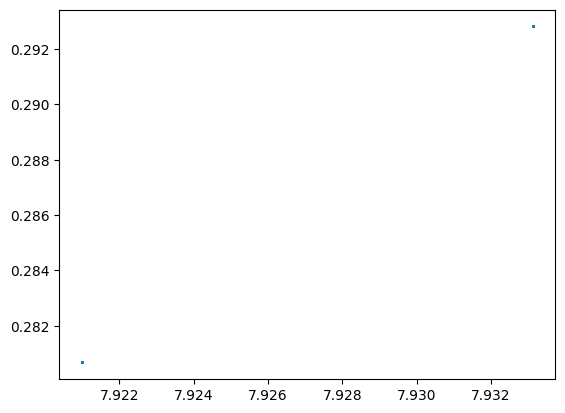

In [16]:
plt.scatter(df_multiple_chains['M_NFW'], df_multiple_chains['t_end'], s=1, alpha=0.1)

/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/chainconsumer/plotter.py:861: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(base.extents[p2])
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/chainconsumer/plotter.py:860: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(base.extents[p1])
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


IndexError: index 0 is out of bounds for axis 0 with size 0

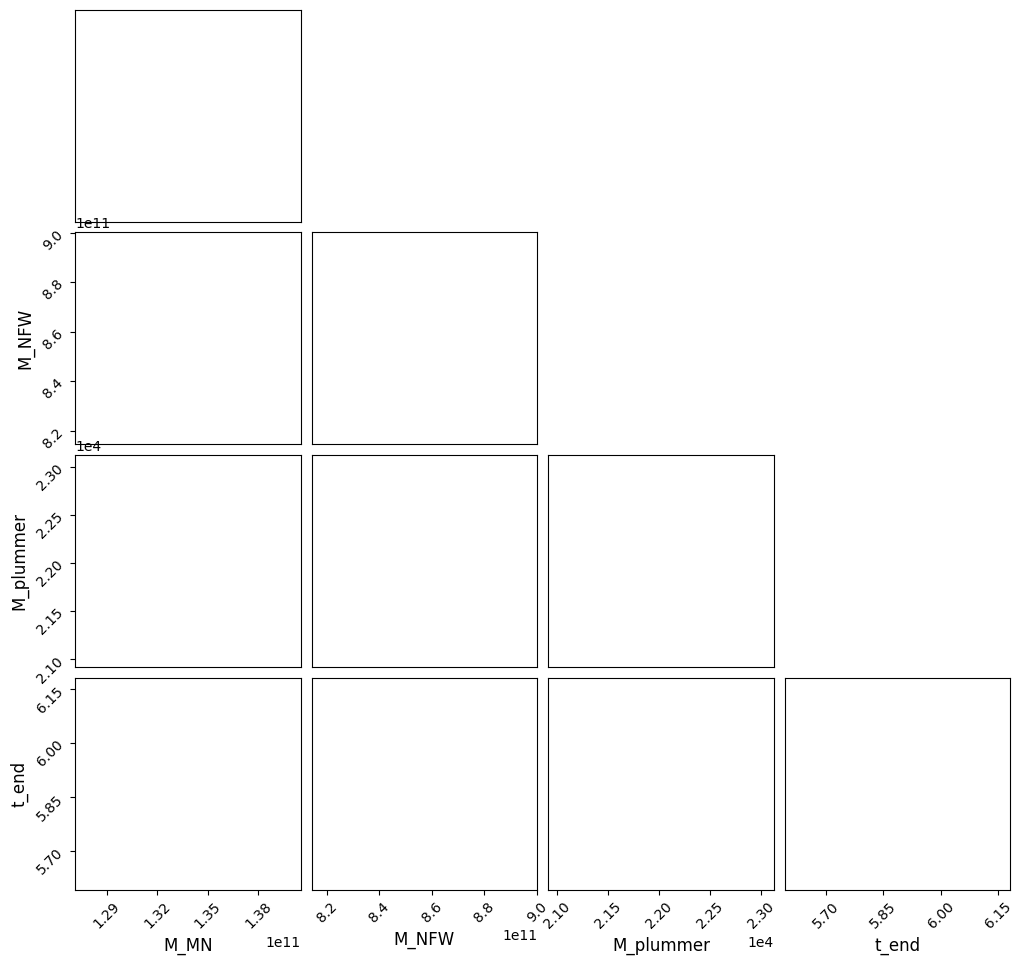

In [17]:
df_multiple_chains = df_multiple_chains.astype(float)  # Ensure all values are float
df_multiple_chains['M_NFW'] = 10**df_multiple_chains['M_NFW'] * code_units.code_mass.to(u.Msun)
df_multiple_chains['t_end'] = 10**df_multiple_chains['t_end'] * code_units.code_time.to(u.Gyr)
df_multiple_chains['M_plummer'] = 10**df_multiple_chains['M_plummer'] * code_units.code_mass.to(u.Msun)
df_multiple_chains['M_MN'] = 10**df_multiple_chains['M_MN'] * code_units.code_mass.to(u.Msun)
c = ChainConsumer()
c.add_chain(Chain(samples=df_multiple_chains, name='Langevin samples'))
c.add_truth(Truth(location={'M_NFW': params.NFW_params.Mvir* code_units.code_mass.to(u.Msun), 
                            't_end': params.t_end * code_units.code_time.to(u.Gyr),
                            'M_plummer': params.Plummer_params.Mtot * code_units.code_mass.to(u.Msun),
                            'M_MN': params.MN_params.M * code_units.code_mass.to(u.Msun)}), )
fig = c.plotter.plot()

In [18]:
xdata = xr.Dataset.from_dataframe(df_multiple_chains)
idata = az.InferenceData(posterior=xdata)
idata

Inference data with groups:
	> posterior

/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/arviz/stats/diagnostics.py:992: RuntimeWarning: invalid value encountered in sqrt
  mcse_sd_value = np.sqrt(varsd)
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/export/home/vgiu

                   mean            sd        hdi_3%       hdi_97%  \
M_MN       1.319870e+11  1.845441e+09  1.301425e+11  1.338315e+11   
M_NFW      8.454757e+11  1.182236e+10  8.336592e+11  8.572921e+11   
M_plummer  2.171629e+04  3.036440e+02  2.141279e+04  2.201978e+04   
t_end      5.806000e+00  8.100000e-02  5.725000e+00  5.888000e+00   

              mcse_mean  mcse_sd  ess_bulk  ess_tail         r_hat  
M_MN       1.294442e+09      NaN       2.0    1000.0  9.898116e+15  
M_NFW      8.292526e+09   79.935       2.0       2.0  9.898116e+15  
M_plummer  2.129840e+02    0.000       2.0       2.0  9.898116e+15  
t_end      5.700000e-02    0.000       2.0       2.0  9.898116e+15  


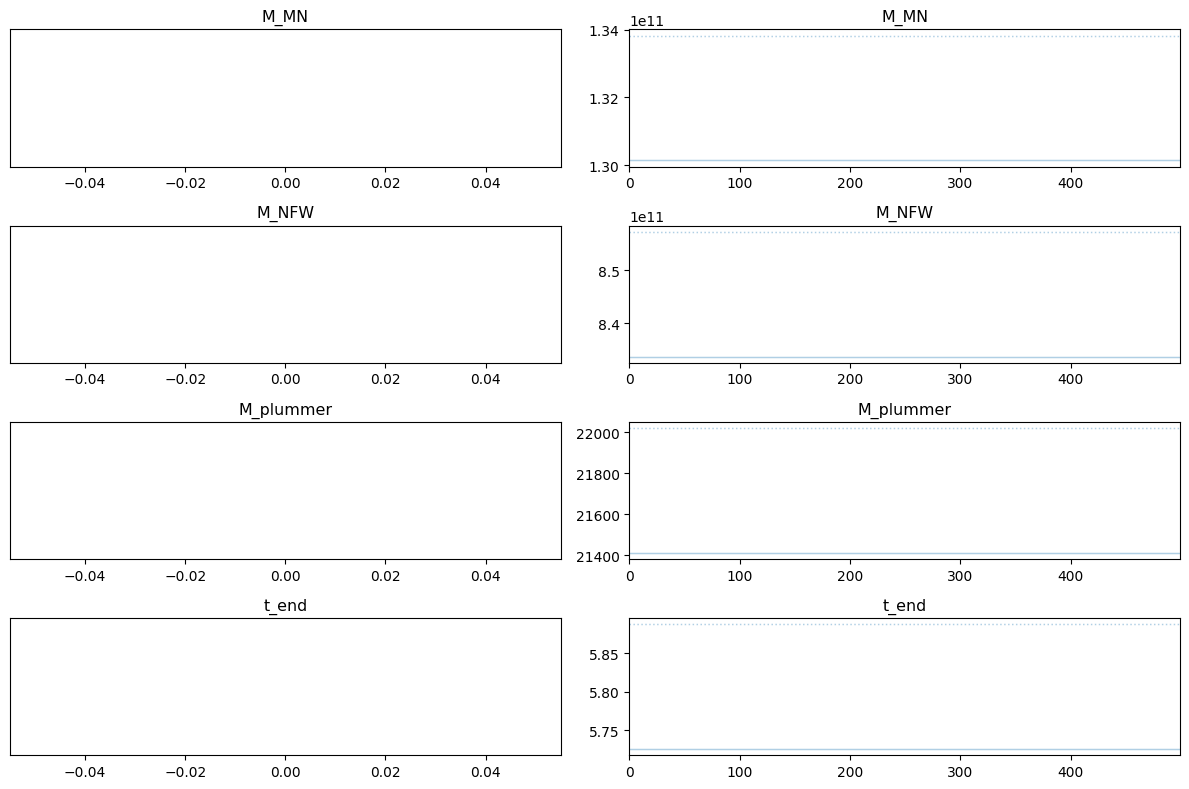

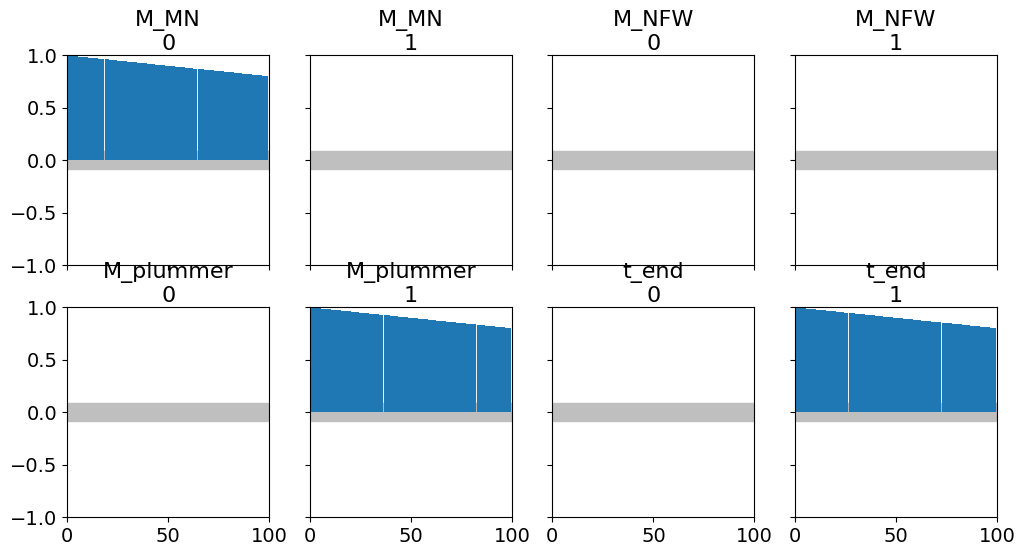

Effective Sample Size:
<xarray.Dataset> Size: 32B
Dimensions:    ()
Data variables:
    M_MN       float64 8B 2.033
    M_NFW      float64 8B 2.033
    M_plummer  float64 8B 2.033
    t_end      float64 8B 2.033
Monte Carlo Standard Error:
<xarray.Dataset> Size: 32B
Dimensions:    ()
Data variables:
    M_MN       float64 8B 1.294e+09
    M_NFW      float64 8B 8.293e+09
    M_plummer  float64 8B 213.0
    t_end      float64 8B 0.05695


In [19]:
# Summary statistics including R-hat, ESS, etc.
summary = az.summary(idata)
print(summary)

# Plot trace plots to visualize convergence
az.plot_trace(idata, figsize=(12, 8))
plt.tight_layout()
plt.show()

# Plot autocorrelation
az.plot_autocorr(idata, figsize=(12, 6))
plt.show()

# Effective sample size
ess = az.ess(idata)
print("Effective Sample Size:")
print(ess)

# Monte Carlo Standard Error
mcse = az.mcse(idata)
print("Monte Carlo Standard Error:")
print(mcse)